<center> <H1>SCALE INVARIANT FEATURE TRANSFORM</H1></center>

In [363]:
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns

The major stages for SIFT computations used:
1) Scale-Space Extrema detection
2) Keypoints localization
3) Orientation assignement
4) Keypoint Descriptor

<h2> 1) Scale-space Extrema Detection

In [373]:
image = cv.imread('project/queries/matricule1.png',0)
blurred_im = cv.GaussianBlur(image, (3,3), 100)

# fig,(ax1 ,ax2) = plt.subplots(1,2, figsize = (10,10))
# ax1.imshow(image, cmap="gray")
# ax2.imshow(blurred_im, cmap="gray")


Scale space being is a collection of images having different scales.

We'll take the original image and lower the scale by half to make a new series of images with varying scales. We'll make blurred versions of each new image.

This is just to see how the process is done, later we'll use the SIFT functions to detect and compute the features.

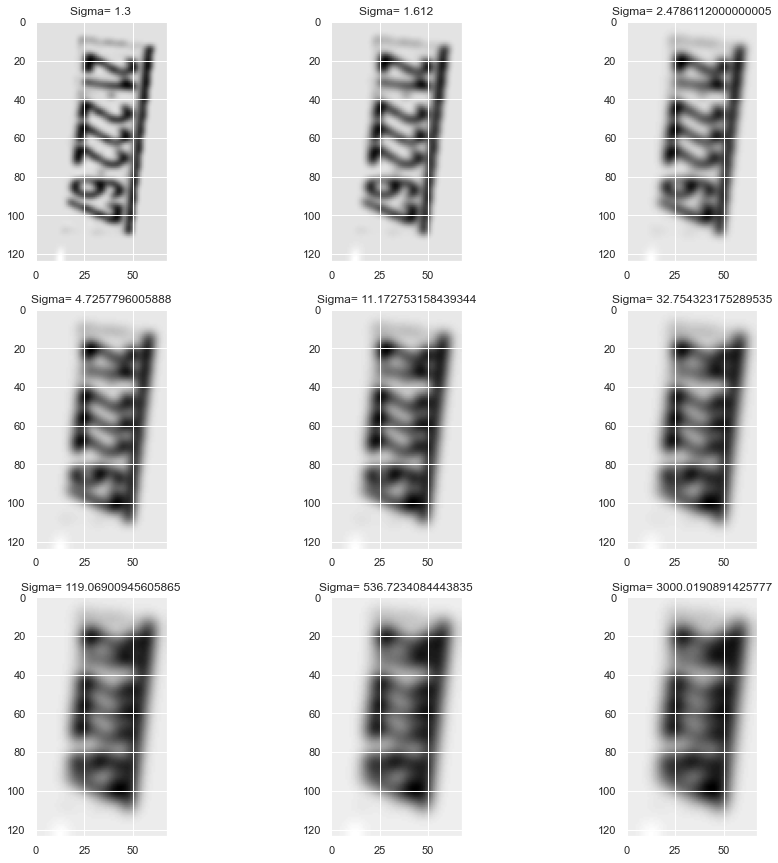

In [374]:
def calculate_gaussians(blurred_im):
    fig ,axs = plt.subplots(3,3, figsize =(15,15) )
    axs = axs.ravel()
    sigma = 1.3
    k = 1.24

    for i in range(1,10):
        blurred_im = cv.GaussianBlur(blurred_im, (5,5), sigmaX=sigma)
        axs[i-1].imshow(blurred_im, cmap = "gray")
        axs[i-1].set_title('Sigma= %s' %sigma)
        sigma = sigma*k**i
calculate_gaussians(blurred_im)

#  SIFT detector 

In [375]:

sns.set()
#read a query
licence_plate = cv.imread('Project\queries\matricule4.png')
licence_plate = cv.cvtColor(licence_plate, cv.COLOR_BGR2RGB)
licencePlate_gray = cv.cvtColor(licence_plate, cv.COLOR_RGB2GRAY)

#initializing SIFT feature detector and detecting keypoints and descriptors
sift = cv.SIFT_create()

plate_keypoints, plate_descriptors = sift.detectAndCompute(licencePlate_gray,None)
print('Number of keypoints : ',len(plate_keypoints))
print('number of descriptors in each keypoint:',plate_descriptors.shape[1])

Number of keypoints :  155
number of descriptors in each keypoint: 128


The following informations are extracted for each KEYPOINT:

1) keypoint location (x,y)
2) angle $\theta $ : the orientation of the keypoint.
3) Size (diameter), which is proportional to the size of the current Octave
4) response: the value to filter only strong keypoints
5) octave: which octave the keypoint has been extracted from.
6) class id



In [376]:
print('Example of one extracted Keypoint characteristics:')
print('x,y ',plate_keypoints[10].pt)
print('size:',plate_keypoints[10].size)
print('angle:',plate_keypoints[10].angle)
print('response:',plate_keypoints[10].response)
print('class_id:',plate_keypoints[10].class_id)
print('octave:',plate_keypoints[10].octave)

Example of one extracted Keypoint characteristics:
x,y  (21.180644989013672, 134.6555938720703)
size: 1.8854697942733765
angle: 327.42901611328125
response: 0.03759145364165306
class_id: -1
octave: 3539455


In [377]:
# the discriptor of one keypoint
plate_descriptors[0]


array([  0.,   0.,   0.,   0.,   0.,   3.,   3.,   2.,   0.,   0.,   0.,
         0.,   0.,   4.,  35.,  27.,   0.,   0.,   0.,   0.,   0.,   8.,
       132.,  11.,   2.,   3.,   0.,   0.,   0.,   1., 133.,  28.,   9.,
         0.,   0.,   0.,   0.,   5.,  10.,  12., 107.,   2.,   0.,   0.,
         0.,   1.,  69., 141.,  18.,   0.,   0.,   0.,   0.,   2., 141.,
        79.,  46.,   1.,   0.,   0.,   0.,   0., 141., 141.,  15.,   1.,
         0.,   0.,   0.,   2.,   4.,   3., 141.,  39.,   0.,   0.,   0.,
         1.,   6.,  31., 120.,  10.,   0.,   0.,   0.,   3.,  79.,  38.,
       108.,   8.,   0.,   0.,   0.,   1.,  56.,  38.,   2.,   0.,   0.,
         0.,   0.,   1.,   7.,   4., 141.,  20.,   0.,   0.,   0.,   1.,
        23.,  71., 141.,  10.,   0.,   0.,   0.,   3.,  44.,  73.,  39.,
         2.,   0.,   0.,   0.,   4.,  60.,  24.], dtype=float32)

<AxesSubplot:title={'center':'Histogram of Oriented Direction for keypoint 1'}, xlabel='Orientation (degree)', ylabel='Count'>

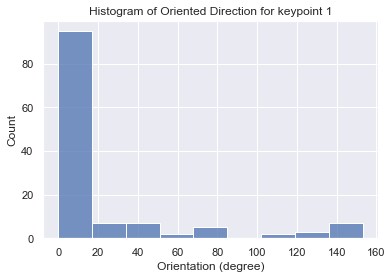

In [378]:
plt.title('Histogram of Oriented Direction for keypoint 1')
plt.xlabel('Orientation (degree)')
sns.histplot(data=plate_descriptors[0], binwidth=17,bins=8)

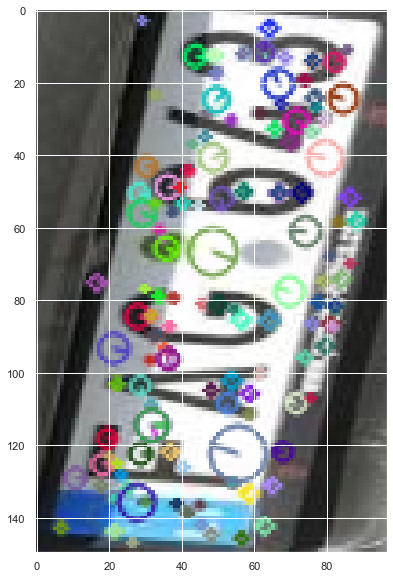

In [379]:
#drawing keypoints

plate_features  = cv.drawKeypoints(licence_plate, plate_keypoints, None ,flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,10))
plt.imshow(plate_features)

Now we need to match the located keypoints with another image. The Brute Force Matcher in Opencv handles this, but how doest it work?
what do we match on the basis of?
what happens is that it creates 4 histograms for the 16*16 windows used to detect the keypoints, and arrange the four histograms in a 128 bins, then calculate the DISTANCE of histograms between the current keypoint and every other keypoint located on the other image. if the Distance is 0, the we have a perfect match.


We proceed by testing every provided car images with the selected licence plate and check the number of matched features, for that we choose a thereshold of 10 good Features in order to match two images, otherwise we continue looping in the images folder.

In [380]:

#calculating keypoints and descriptor for the car image
def MatchFeatures(gray_image):
    car_keypoints, car_descriptor = sift.detectAndCompute(gray_image, None)

    #car_features = cv.drawKeypoints(car, car_keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(plate_descriptors,car_descriptor, k=2)

    good_features = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
          good_features.append([m])
    
    #we check if the number of good features is above 10
    return good_features, car_keypoints
        
  



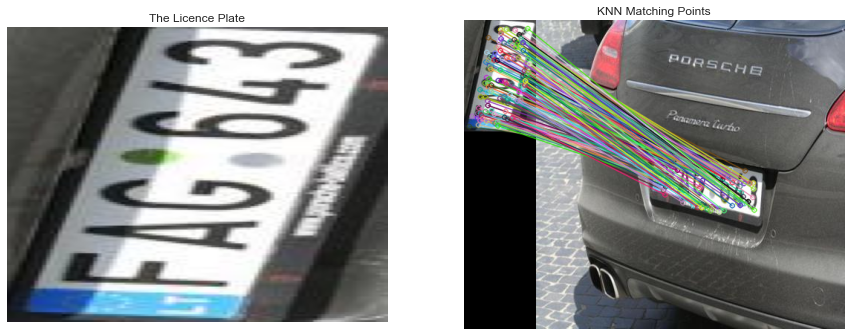

In [381]:
import os
# Load the test image
folder_dir = "project/License Plates"


for images in os.listdir(folder_dir):
    image = cv.imread(os.path.join(folder_dir, images))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    good_features, car_keypoints = MatchFeatures(image_gray)
    if(len(good_features) < 10):
        continue
    else:
        matched_car = image # the car image with the matching licence plate
        break

if(matched_car.any() != None):

    comparaison = cv.drawMatchesKnn(licence_plate, plate_keypoints, matched_car, car_keypoints, good_features,None, flags = 2)
    # Display the best matching points
    fig ,(ax1,ax2) = plt.subplots(1,2, figsize =(15,15) )
    
    ax1.axis('off')
    ax2.axis('off')

    
    ax1.imshow(licence_plate,)
    ax1.set_title("The Licence Plate")
    ax1.set_aspect(0.5)
    plt.title('KNN Matching Points')
    ax2.imshow(comparaison)
    plt.show()
   
else:
    print("empty !")